# Starbucks Customer Data (Data Understanding)

This notebook has been created to gain an initial data understanding of the datasets provided by Starbucks on their customer behaviour in the context of their incentivised marketing campagins. It will specifically address what data points they have provided, any missing data or how they could be used in terms of predicting future marketing efforts.

The files looked at in this notebook are:
- portfolio.json: containing offer ids and meta data about each offer (duration, type, etc.)
- profile.json: demographic data for each customer
- transcript.json: records for transactions, offers received, offers viewed, and offers completed

### Imports

In [1]:
import pandas as pd
import numpy as np
import json

# plotting functions
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import matplotlib.style as style

### Functions

In [2]:
def plot_histogram(data, column, ax, binsize=50, y_label='', x_label='', color='blue'):
    """
    Function to plot standard histograms (Can be used for individual or side by side plots)
    """
    # Plots the Graph with title & axis
    sns.distplot(data[column], kde=False, color=color, bins=binsize, ax=ax)
    
    # Sets up the title based the column    
    ax.set_title(f"Spread of {column}", fontsize=25)
    
    # Sets the y and x labels
    ax.set_ylabel(y_label, fontsize=24)
    ax.set_xlabel(x_label, fontsize=24)
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
        
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20) 
    
    # Removes spines and changes layout to tight
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
def plot_line(data, ax, color, alpha=.7, ls='-', lw=5, label=None):
    """
    plots the standard line graph
    """
    ax.plot(data, color=color,
            alpha=alpha, ls=ls,
            linewidth=lw, label=label)

### Global Variables

The first thing I will do is load in each of the data files and look at which variables they each contain to gain some understanding of each of the datasets:

In [2]:
# read in each of the data files & look at the variables involved
portfolio_df = pd.read_json('/content/portfolio.json', lines=True)
portfolio_df.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [3]:
profile_df = pd.read_json('/content/profile.json', lines=True)
profile_df.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [11]:
transcript_df = pd.read_json('/content/transcript.json', lines=True)
transcript_df.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


### Initial Analysis

Next I will perform some initial analysis this will just be very basic to check missing data, values in each column etc and will provide the basis for the processing in the next step of the process. It will also allow me to start planning how I will progress with the project in terms of processing and modeling in the next few notebooks.

#### Portfolio data

First I will get a very basic overview of all of the variables of the portfolio dataset. This dataset contains information on all of the offers ran by Starbucks in the observation period.

In [12]:
# First I'll look at the shape portfolio data
portfolio_df.shape

(10, 6)

In [13]:
# look into the types of offers available
portfolio_df['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [14]:
# look into the spread of the numerical data difficulty, duration & reward
portfolio_df.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [15]:
# find all the differenr types of channels that the campagins were displayed on
portfolio_df.channels

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

From the above analysis I can see that 10 different campaigns where ran with three different types of offer deployed these were bogo (Buy One Get One Free), informational and discounts. They were distributed across the web, email, mobile and social media. They ranged in length between 10 and 3 days. Had an average difficulty (minimum spend) of 8.5 dollars and an average reward of 4 dollars.

#### Profile data

Next I will look at the user profile data to see what information we have on individual consumers.

In [16]:
profile_df.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [17]:
# see how many consumers are in the profile dataset
profile_df.shape

(17000, 5)

In [18]:
# check the spread of ages and income in the data
profile_df.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [19]:
# check spread of data in the gender column
profile_df.groupby('gender').count()

,age,id,became_member_on,income
gender,,,,
F,6129,6129,6129,6129
M,8484,8484,8484,8484
O,212,212,212,212


In [20]:
# check the spread of dates from when users became a member
pd.to_datetime(profile_df['became_member_on']).describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


count                             17000
unique                             1716
top       1970-01-01 00:00:00.020171207
freq                                 43
first     1970-01-01 00:00:00.020130729
last      1970-01-01 00:00:00.020180726
Name: became_member_on, dtype: object

In [21]:
# see how many missing values are in the income column
profile_df['income'].isna().sum()

2175

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


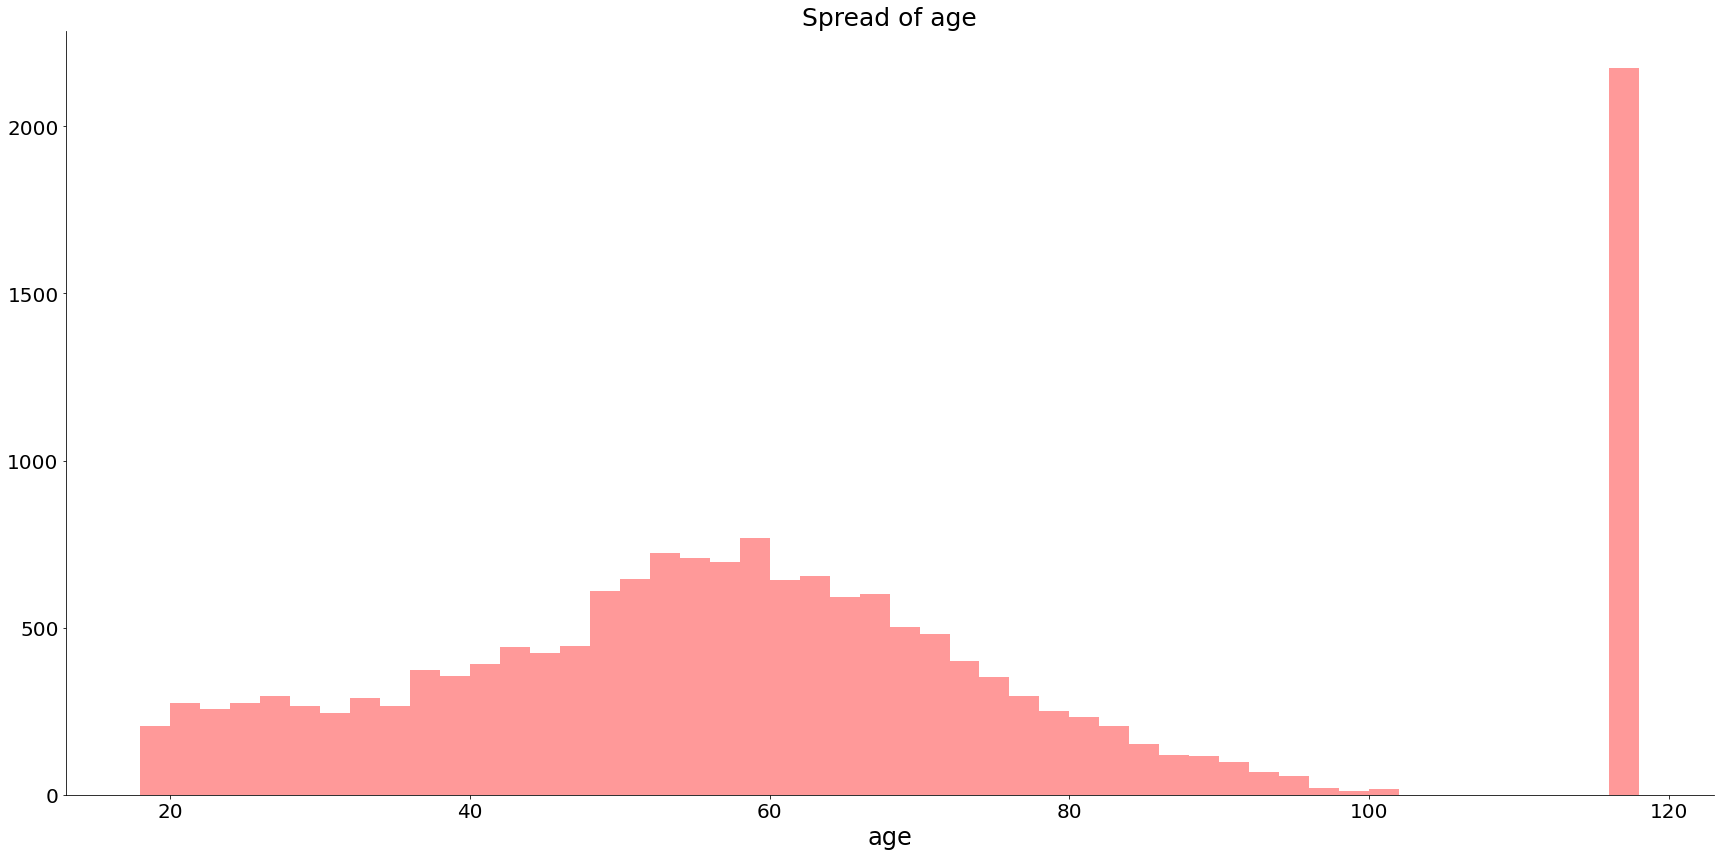

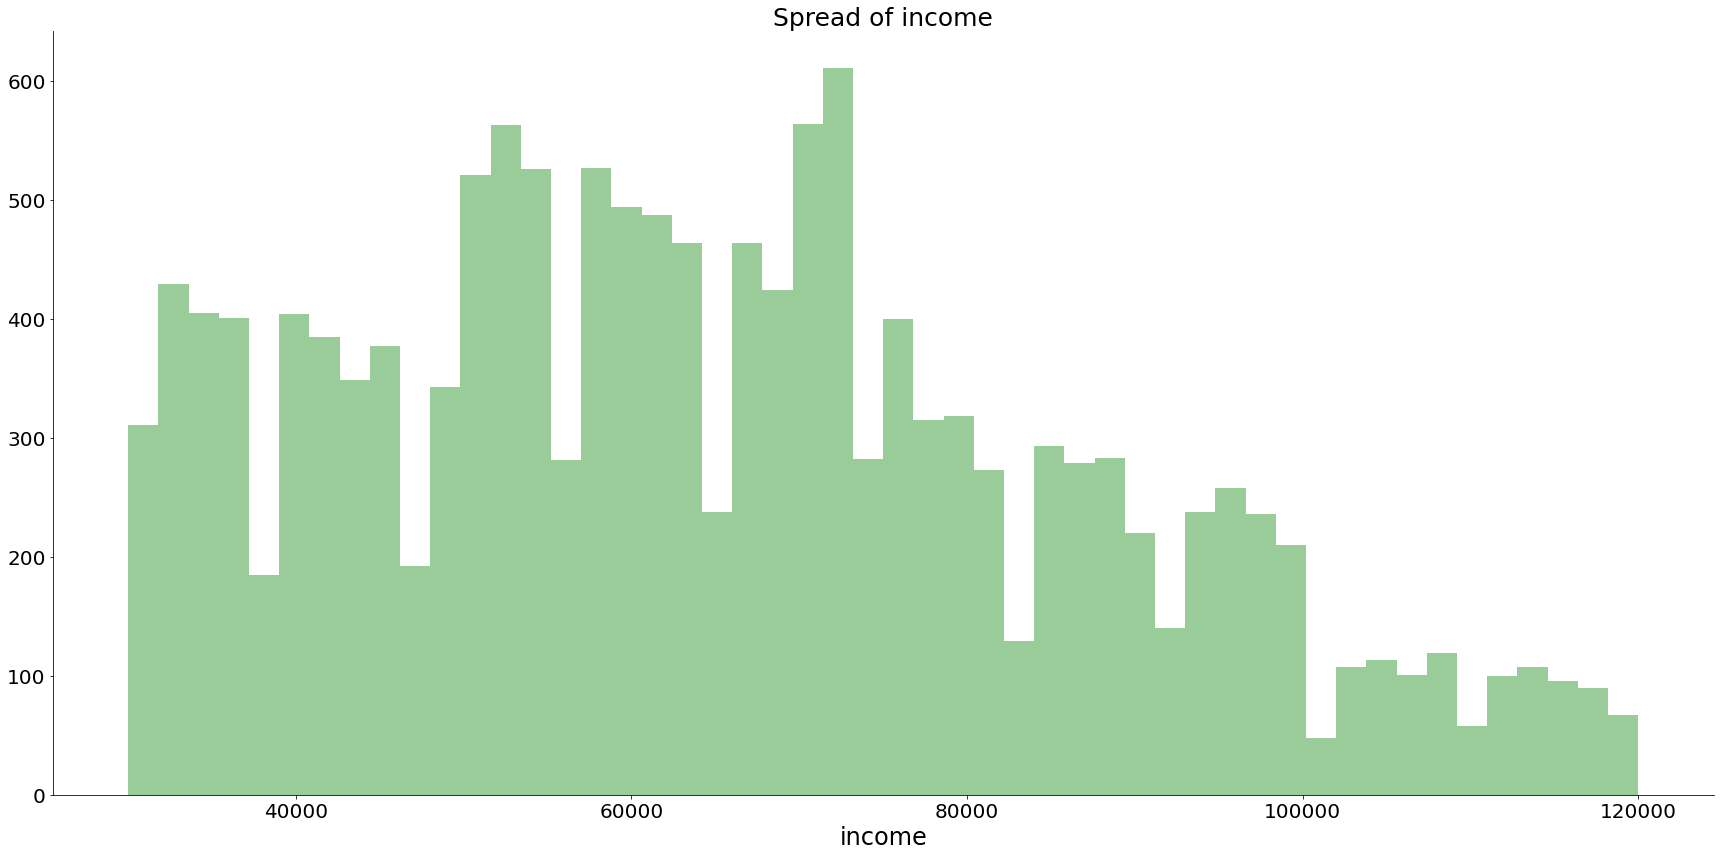

In [22]:
columns = ['age','income']
colors = ['red','green']

# plot histograms to visually show the spread of data
for column in columns:
    # Setup the graphs and add the main title
    fig, ax1 = plt.subplots(figsize=(24,12))

    # Plots the Seattle Graph with title & axis
    plot_histogram(profile_df, column, ax1, binsize=50, 
                   x_label=f'{column}', color=colors[columns.index(column)])

    plt.tight_layout()

From the profile data I can see that their are 17,000 consumers in the dataset with ~6100 female, ~8400 male and ~200 unknown. The users joined between 29th July 2013 and 26th July 2018. We have data on around 15,000 of the users that have an income between 30,000-120,000 with the average of 64,000. The ages range from 18 to greater than 73 however it seems that no age has been specified as for some and instead has been set at 118, this could be users who are more aware of sharing personal data. It is would be worth removing this when running the analysis and either zeroing them so that they are treated as there own dataset or adding a dummy value for the average age.

#### Transcript data

Finally, I will look at the transcript data that contains information on all of the transactions throughout the 30 day period.

In [23]:
transcript_df.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [24]:
# how many interactions have been encountered
transcript_df.shape

(306534, 4)

In [25]:
# look into how the time column is formatted/the spread of the data
transcript_df.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [26]:
# see how many people received the offers and how many didn't
transcript_df.groupby('event').count()

,person,value,time
event,,,
offer completed,33579,33579,33579
offer received,76277,76277,76277
offer viewed,57725,57725,57725
transaction,138953,138953,138953


In [27]:
# number of unique users in the dataset
len(transcript_df['person'].unique())

17000

In [28]:
# see if there is any missing data in the dataset
transcript_df.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [29]:
# look at the values column
transcript_df_copy = transcript_df
transcript_df_copy['type'] = [list(x.keys())[0] for x in transcript_df['value']]
transcript_df_copy['campaign'] = [list(x.values())[0] for x in transcript_df['value']]
transcript_df_copy.groupby('type').count()

,person,event,value,time,campaign
type,,,,,
amount,138953,138953,138953,138953,138953
offer id,134002,134002,134002,134002,134002
offer_id,33579,33579,33579,33579,33579


Frome the transcript data we can see that 306,534 events have been logged by starbucks and the majority of these (138,953) are transactions, with ~76000 offers received, ~58,00 viewed and 33,579 completed. The time column ranges from zero to 714 minutes and shows the time throughout the observation period with a max of around 30 days as expected. The dataset contains all of the 17,000 users that are in the profile data. The value column contains either the campagin ids or the amount spent on the transactions processed.

### Next steps

Now that we have a basic level of understanding of the core input datasets it's possible to plan out the processing and modeling stages of the project in a little bit more depth. As the aim of the project is to perform demographics clustering and regression modeling to predict spend I Will need to create two core input datasets for the modeling. 

The first dataset will be for the demographic grouping and will need to be made from the profile data to get background information on the user but also spend so we can see what the user normally is spending. To gain this spend I will also have to flag the difference between transfers that have been influenced by offers and ones that haven't so I can see normal user behaviour. This should probably be the first step.

For the second dataset we have a number of options of trying to predict spend by day or by transaction. Trying to predict spend by transaction presents a more difficult problem of actually predicting the probability of a transaction actually happening. With this dataset that would be difficult as I only have 30 days of data and all of the marketing overlaps meaning a baseline of if a user will make a transaction or not would have to be made on very limited data. Therefore in this modeling I will assume that I know the transactions that will be influenced and create my modeling off the back of that. The input dataset therefore should have the spend and if any transactions where influenced on that given day. From this we can predict the increase in spend and how successful the marketing models are.

In the next section I will work on creating the above input datasets.

In [42]:
def clean_transcript_data(data):
    """
    this process cleans the values column and formats the transcript data
    """
    # creates a column for the type of interaction   
    data['interaction_value'] = [list(x.keys())[0] for x in data['value']]
    
    # creates a column related to the value amount or id    
    data['id'] = [list(x.values())[0] for x in data['value']]
    
    # drops the value column
    data = data.drop(columns=['value'])
    
    # cleans the interaction type column so offer id is consistent
    data['interaction_value'] = [x.replace('offer id','offer_id') for x in data['interaction_value']]
    
    # split out interaction_type
    temp_df = pd.get_dummies(data['interaction_value'])

    # combine the dataframes
    data = pd.concat([temp_df, data], axis=1, sort=True)
    
    # split out event
    temp_df = pd.get_dummies(data['event'])

    # combine the dataframes
    data = pd.concat([temp_df, data], axis=1, sort=True)

    # drop the original columns
    data = data.drop(columns=['interaction_value','event'])    
    
    return data # returns the clean transcript data


def clean_profile_data(data):
    """
    this process clean age, income and became_member_on columns in the profile data
    """
    # rename the column 'id' to person
    data.columns = ['age','member joined','gender','person' ,'income']
    
    # replace 118 in the age column with a zero indicating no age 
    # keeping these users as a seperate group is important as they may show different user behaviour
    data['age'] = data['age'].replace(118,0)

    # update the became_member_on column to a datetime format
    data['member joined'] = pd.to_datetime(data['member joined'], format='%Y%m%d')
    
    # replace the NaN's in the income
    data['income'] = data['income'].fillna(0)
    
    # replace M, F, O and None types to get the 4 groups of customers
    data['gender'] = data['gender'].replace('M','male')
    data['gender'] = data['gender'].replace('F','female')
    data['gender'] = data['gender'].replace('O','other')
    data['gender'] = data['gender'].fillna('unknown gender')

    # split the column into seperate columns
    temp_df = pd.get_dummies(data['gender'])

    # combine the dataframes
    data = pd.concat([temp_df, data], axis=1, sort=True)

    # drop the original column
    data = data.drop(columns=['gender'])

    return data

def clean_portfolio_data(data):
    """
    this process has been created to clean columns in the profile data
    """
    # splits the channels column into seperate columns
    # creates temporary dataframes and lists  
    temp_df = pd.DataFrame(columns=['web', 'email', 'mobile','social'])
    temp_list = []

    # loop through the rows and attach the values to a dic   
    for index, row in data.iterrows():
        for value in row['channels']:
             temp_list.append({'index': index, 'value':value})

    # change the list into dataframe
    temp_df = temp_df.append(temp_list, ignore_index=False, sort=True)
    temp_df = temp_df.groupby('index')['value'].value_counts()
    temp_df = temp_df.unstack(level=-1).fillna(0)
    
    # combine the dataframes
    data = pd.concat([temp_df, data], axis=1, sort=True)
    
    # split the column into seperate columns
    temp_df = pd.get_dummies(data['offer_type'])

    # combine the dataframes
    data = pd.concat([temp_df, data], axis=1, sort=True)

    # drop the original columns
    data = data.drop(columns=['offer_type','channels'])
    
    return data

In [63]:
def clean_transcript_data(data):
    """
    this process cleans the values column and formats the transcript data
    """
    # creates a column for the type of interaction   
    data['interaction_value'] = [list(x.keys())[0] for x in data['value']]
    
    # creates a column related to the value amount or id    
    data['id'] = [list(x.values())[0] for x in data['value']]
    
    # drops the value column
    data = data.drop(columns=['value'])
    
    # cleans the interaction type column so offer id is consistent
    data['interaction_value'] = [x.replace('offer id','offer_id') for x in data['interaction_value']]
    
    # split out interaction_type
    temp_df = pd.get_dummies(data['interaction_value'])

    # combine the dataframes
    data = pd.concat([temp_df, data], axis=1, sort=True)
    
    # split out event
    temp_df = pd.get_dummies(data['event'])

    # combine the dataframes
    data = pd.concat([temp_df, data], axis=1, sort=True)

    # drop the original columns
    data = data.drop(columns=['interaction_value','event'])    
    
    return data # returns the clean transcript data


def clean_profile_data(data):
    """
    this process clean age, income and became_member_on columns in the profile data
    """
    # rename the column 'id' to person
    data.columns = ['age','member joined','gender','person' ,'income']
    
    # replace 118 in the age column with a zero indicating no age 
    # keeping these users as a seperate group is important as they may show different user behaviour
    data['age'] = data['age'].replace(118,0)

    # update the became_member_on column to a datetime format
    data['member joined'] = pd.to_datetime(data['member joined'], format='%Y%m%d')
    
    # replace the NaN's in the income
    data['income'] = data['income'].fillna(0)
    
    # replace M, F, O and None types to get the 4 groups of customers
    data['gender'] = data['gender'].replace('M','male')
    data['gender'] = data['gender'].replace('F','female')
    data['gender'] = data['gender'].replace('O','other')
    data['gender'] = data['gender'].fillna('unknown gender')

    # split the column into seperate columns
    temp_df = pd.get_dummies(data['gender'])

    # combine the dataframes
    data = pd.concat([temp_df, data], axis=1, sort=True)

    # drop the original column
    data = data.drop(columns=['gender'])

    return data

def clean_portfolio_data(data):
    """
    this process has been created to clean columns in the profile data
    """
    # splits the channels column into seperate columns
    # creates temporary dataframes and lists  
    temp_df = pd.DataFrame(columns=['web', 'email', 'mobile','social'])
    temp_list = []

    # loop through the rows and attach the values to a dic   
    for index, row in data.iterrows():
        for value in row['channels']:
             temp_list.append({'index': index, 'value':value})

    # change the list into dataframe
    temp_df = temp_df.append(temp_list, ignore_index=False, sort=True)
    temp_df = temp_df.groupby('index')['value'].value_counts()
    temp_df = temp_df.unstack(level=-1).fillna(0)
    
    # combine the dataframes
    data = pd.concat([temp_df, data], axis=1, sort=True)
    
    # split the column into seperate columns
    temp_df = pd.get_dummies(data['offer_type'])

    # combine the dataframes
    data = pd.concat([temp_df, data], axis=1, sort=True)

    # drop the original columns
    data = data.drop(columns=['offer_type','channels'])
    
    return data

In [64]:
# read in the different datasources
portfolio_df = pd.read_json('/content/portfolio.json', lines=True)
profile_df = pd.read_json('/content/profile.json', lines=True)
transcript_df = pd.read_json('/content/transcript.json', lines=True)

In [4]:
def clean_profile_data1(data):
    """
    this process clean age, income and became_member_on columns in the profile data
    """
    # rename the column 'id' to person
    data.columns = ['gender','age','person' ,'member joined','income']
    
    # replace 118 in the age column with a zero indicating no age 
    # keeping these users as a seperate group is important as they may show different user behaviour
    data['age'] = data['age'].replace(118,0)

    # update the became_member_on column to a datetime format
    data['member joined'] = pd.to_datetime(data['member joined'], format='%Y%m%d')
    
    # replace the NaN's in the income
    data['income'] = data['income'].fillna(0)
    
    # replace M, F, O and None types to get the 4 groups of customers
    data['gender'] = data['gender'].replace('M','male')
    data['gender'] = data['gender'].replace('F','female')
    data['gender'] = data['gender'].replace('O','other')
    data['gender'] = data['gender'].fillna('unknown gender')

    # split the column into seperate columns
    temp_df = pd.get_dummies(data['gender'])

    # combine the dataframes
    data = pd.concat([temp_df, data], axis=1, sort=True)

    # drop the original column
    data = data.drop(columns=['gender'])

    return data

In [80]:
profile_df

,age,member joined,gender,person,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [71]:
# run the initial cleaning on each dataset
clean_port_df = clean_portfolio_data(portfolio_df)
clean_port_df

,bogo,discount,informational,email,mobile,social,web,reward,difficulty,duration,id
0.0,1,0,0,1.0,1.0,1.0,0.0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd
1.0,1,0,0,1.0,1.0,1.0,1.0,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0
2.0,0,0,1,1.0,1.0,0.0,1.0,0,0,4,3f207df678b143eea3cee63160fa8bed
3.0,1,0,0,1.0,1.0,0.0,1.0,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9
4.0,0,1,0,1.0,0.0,0.0,1.0,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7
5.0,0,1,0,1.0,1.0,1.0,1.0,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2
6.0,0,1,0,1.0,1.0,1.0,1.0,2,10,10,fafdcd668e3743c1bb461111dcafc2a4
7.0,0,0,1,1.0,1.0,1.0,0.0,0,0,3,5a8bc65990b245e5a138643cd4eb9837
8.0,1,0,0,1.0,1.0,1.0,1.0,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d
9.0,0,1,0,1.0,1.0,0.0,1.0,2,10,7,2906b810c7d4411798c6938adc9daaa5


In [65]:
profile_df

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [5]:
clean_prof_df = clean_profile_data1(profile_df)
clean_prof_df.head()

,female,male,other,unknown gender,age,person,member joined,income
0,0,0,0,1,0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,0.0
1,1,0,0,0,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,0,0,0,1,0,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,0.0
3,1,0,0,0,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,0,0,0,1,0,a03223e636434f42ac4c3df47e8bac43,2017-08-04,0.0


In [82]:
clean_trans_df = clean_transcript_data(transcript_df)
clean_trans_df.head()

,offer completed,offer received,offer viewed,transaction,amount,offer_id,person,time,id
0,0,1,0,0,0,1,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,0,1,0,0,0,1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,0,1,0,0,0,1,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5
3,0,1,0,0,0,1,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4
4,0,1,0,0,0,1,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [83]:
def transactions(data):
    """
    returns all the transactions from the transcript dataframe
    """
    transactions_df = data[data['transaction'] == 1]
    transactions_df = transactions_df[['person','time','id']]
    transactions_df.columns = ['person','transaction_time','spend']
    
    return transactions_df

In [84]:
# split out the all the transactions

transactions_df = transactions(clean_trans_df)
transactions_df.shape

(138953, 3)

In [85]:
transactions_df.head()

,person,transaction_time,spend
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [86]:
def offers(transcript_data, portfolio_data):
    """
    returns all of the offers that were received/viewed/completed combined with portfolio data
    """
    # keep only the recived offers
    received_offer = transcript_data[transcript_data['offer received'] == 1]
    received_offer = received_offer[['offer received','person', 'time', 'id']]
    received_offer.columns = ['offer received','person', 'time_received', 'id_offer']    
    
    # keep only the viewed offers
    veiwed_offer = transcript_data[transcript_data['offer viewed'] == 1]
    veiwed_offer = veiwed_offer[['offer viewed','person', 'time', 'id']]
    veiwed_offer.columns = ['offer viewed','person', 'time_viewed', 'id_offer']
    
    # keep all the offers completed data as informational campaigns don't have a completed flag
    completed_offer = transcript_data
    completed_offer = completed_offer[['offer completed','person', 'time', 'id']]
    completed_offer.columns = ['offer completed','person', 'time_completed', 'id_offer']
    
    # merge the offers data into one dataframe based on id and person
    merged_veiws = received_offer.merge(veiwed_offer, on=['person','id_offer']) 
    merged_completed = merged_veiws.merge(completed_offer, on=['person','id_offer']) 
    
    # drop anywhere the offer was recived after being viewed 
    # (not useful as it suggests it was a different offer)
    merged_completed = merged_completed[merged_completed['time_viewed'] > 
                                        merged_completed['time_received']]
    
    # merges all of the offer data with info in the portfolio data
    portfolio_data = portfolio_data.rename(columns = {'id':'id_offer'})
    offers = merged_completed.merge(portfolio_data, on=['id_offer'])
    
    # change duration time to hours
    offers['duration'] = offers['duration']*24
    
    return offers

def influenced_bogo(transcript_data, portfolio_data):
    """
    this function has been created to keep only BOGO offers that influenced a purchase
    """
    # gets all of the offers that were received/viewed/completed formatted together
    offer_data = offers(transcript_data, portfolio_data)
    
    # select only the bogo offers and have been completed
    bogo_offers = offer_data[(offer_data['bogo'] == 1) & 
                             (offer_data['offer completed'] == 1)]
    
    # removes any that were completed prior to being viewed
    bogo_offers = bogo_offers[bogo_offers['time_completed'] >= 
                              bogo_offers['time_viewed']]
    
    # removes offers that were completed outside of the offer timeframe (indicating it was a second offer)
    bogo_offers = bogo_offers[(bogo_offers['duration'] >= (bogo_offers['time_completed'] - 
                                                           bogo_offers['time_received']))
                             ]

    # creates the transaction data
    transactions_data = transactions(transcript_data)
    
    # merge the offers and transactions
    transactions_bogo = transactions_data.merge(bogo_offers, on=['person'])
    
    # filter the tansactions keeping ones that occured at same time as the offer was complete
    transactions_bogo = transactions_bogo[transactions_bogo['transaction_time'] == 
                                          transactions_bogo['time_completed']]
    
    # remove any repeat transactions
    transactions_bogo = transactions_bogo.drop_duplicates(subset=['person','transaction_time','spend'], keep="first")
    
    return transactions_bogo

def influenced_discount(transcript_data, portfolio_data):
    """
    this function has been created to keep only discount offers that influenced a purchase
    """
    # gets all of the offers that were received/viewed/completed formatted together
    offer_data = offers(transcript_data, portfolio_data)
    
    # select only the discuont offers and have been completed
    discount_offers = offer_data[(offer_data['discount'] == 1) & 
                                 (offer_data['offer completed'] == 1)]
    
    # removes any that were completed prior to being viewed
    discount_offers = discount_offers[discount_offers['time_completed'] >= 
                                      discount_offers['time_viewed']]
    
    # removes offers that were completed outside of the timeframe (indicating it was a second offer)
    discount_offers = discount_offers[discount_offers['duration'] >= (discount_offers['time_completed'] - 
                                                                      discount_offers['time_received'])]

    # creates the transaction data
    transactions_data = transactions(transcript_data)
    
    # merge the offers and transactions
    transactions_discount = transactions_data.merge(discount_offers, on=['person'])
    
    # filter the tansactions keeping the ones after the offer was viewed but before it was completed
    transactions_discount = transactions_discount[(transactions_discount['transaction_time'] >= transactions_discount['time_viewed']) &
                                                 (transactions_discount['transaction_time'] <= transactions_discount['time_completed'])]
    
    # remove any repeat transactions
    transactions_discount = transactions_discount.drop_duplicates(subset=['person','transaction_time','spend'], keep="first")
    
    return transactions_discount

def influenced_informational(transcript_data, portfolio_data):
    """
    this function has been created to keep only informational offers that influenced a purchase
    """
    # gets all of the offers that were received/viewed/completed formatted together
    offer_data = offers(transcript_data, portfolio_data)
    
    # select only the informational offers
    info_offers = offer_data[(offer_data['informational'] == 1)]

    # creates the transaction data
    transactions_data = transactions(transcript_data)
    
    # merge the offers and transactions
    transactions_info = transactions_data.merge(info_offers, on=['person'])
    
    # filter the tansactions keeping the ones after the offer was viewed
    transactions_info = transactions_info[(transactions_info['transaction_time'] >= transactions_info['time_viewed'])]
    
    # removes transactions that happened outside of duration timeframe of the offer
    transactions_info = transactions_info[transactions_info['duration'] >= (transactions_info['transaction_time'] - 
                                                                            transactions_info['time_viewed'])]
    
    # remove any repeat transactions
    transactions_info = transactions_info.drop_duplicates(subset=['person','transaction_time','spend'], keep="first")
    
    return transactions_info

In [87]:
inf_discount = influenced_discount(clean_trans_df, clean_port_df)
print(inf_discount.shape)
inf_discount.head()

(15428, 20)


,person,transaction_time,spend,offer received,time_received,id_offer,offer viewed,time_viewed,offer completed,time_completed,bogo,discount,informational,email,mobile,social,web,reward,difficulty,duration
13,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,354,18.42,1,336,2298d6c36e964ae4a3e7e9706d1fb8c2,1,342,1,354,0,1,0,1.0,1.0,1.0,1.0,3,7,168
20,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,474,21.13,1,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,462,1,474,0,1,0,1.0,0.0,0.0,1.0,5,20,240
26,54890f68699049c2a04d415abc25e717,330,15.61,1,168,2298d6c36e964ae4a3e7e9706d1fb8c2,1,186,1,330,0,1,0,1.0,1.0,1.0,1.0,3,7,168
42,bbeb54e861614fc7b22a8844f72dca6c,372,2.36,1,336,2298d6c36e964ae4a3e7e9706d1fb8c2,1,354,1,396,0,1,0,1.0,1.0,1.0,1.0,3,7,168
44,bbeb54e861614fc7b22a8844f72dca6c,390,0.36,1,336,2298d6c36e964ae4a3e7e9706d1fb8c2,1,354,1,396,0,1,0,1.0,1.0,1.0,1.0,3,7,168


In [88]:
inf_bogo = influenced_bogo(clean_trans_df, clean_port_df)
print(inf_bogo.shape)
inf_bogo.head()

(7957, 20)


,person,transaction_time,spend,offer received,time_received,id_offer,offer viewed,time_viewed,offer completed,time_completed,bogo,discount,informational,email,mobile,social,web,reward,difficulty,duration
11,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,540,24.3,1,504,4d5c57ea9a6940dd891ad53e9dbe8da0,1,516,1,540,1,0,0,1.0,1.0,1.0,1.0,10,10,120
19,676506bad68e4161b9bbaffeb039626b,636,17.2,1,576,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,588,1,636,1,0,0,1.0,1.0,0.0,1.0,5,5,168
22,4cbe33c601a5407f8202086565c55111,558,31.72,1,504,ae264e3637204a6fb9bb56bc8210ddfd,1,522,1,558,1,0,0,1.0,1.0,1.0,0.0,10,10,168
33,a04fcfd571034456aaa6d56c0a3fd9b6,660,223.07,1,576,f19421c1d4aa40978ebb69ca19b0e20d,1,612,1,660,1,0,0,1.0,1.0,1.0,1.0,5,5,120
39,227f2d69e46a4899b70d48182822cff6,642,24.7,1,576,ae264e3637204a6fb9bb56bc8210ddfd,1,582,1,642,1,0,0,1.0,1.0,1.0,0.0,10,10,168


In [89]:
inf_informational = influenced_informational(clean_trans_df, clean_port_df)
print(inf_informational.shape)
inf_informational.head()

(10290, 20)


,person,transaction_time,spend,offer received,time_received,id_offer,offer viewed,time_viewed,offer completed,time_completed,bogo,discount,informational,email,mobile,social,web,reward,difficulty,duration
10,54890f68699049c2a04d415abc25e717,534,20.01,1,408,5a8bc65990b245e5a138643cd4eb9837,1,468,0,408,0,0,1,1.0,1.0,1.0,0.0,0,0,72
24,b2f1cd155b864803ad8334cdf13c4bd2,102,17.53,1,0,5a8bc65990b245e5a138643cd4eb9837,1,66,0,0,0,0,1,1.0,1.0,1.0,0.0,0,0,72
30,b2f1cd155b864803ad8334cdf13c4bd2,222,27.45,1,168,3f207df678b143eea3cee63160fa8bed,1,198,0,168,0,0,1,1.0,1.0,0.0,1.0,0,0,96
174,fe97aa22dd3e48c8b143116a8403dd52,198,28.71,1,168,3f207df678b143eea3cee63160fa8bed,1,198,0,168,0,0,1,1.0,1.0,0.0,1.0,0,0,96
236,fe97aa22dd3e48c8b143116a8403dd52,438,380.24,1,408,5a8bc65990b245e5a138643cd4eb9837,1,420,0,408,0,0,1,1.0,1.0,1.0,0.0,0,0,72


In [90]:
# Now that we have all the influenced transactions we can find the ones not influenced by offers
def norm_transactions(clean_trans_df, clean_port_df):
    """
    produces all the transactions that weren't influenced by offers
    """
    # creates the transaction data
    transactions_data = transactions(clean_trans_df)
    
    # all offer affected transactions
    inf_discount = influenced_discount(clean_trans_df, clean_port_df)
    inf_bogo = influenced_bogo(clean_trans_df, clean_port_df)
    inf_informational = influenced_informational(clean_trans_df, clean_port_df)
    
    # combine all the influenced transcations    
    inf_trans = inf_informational.append(inf_discount.append(inf_bogo))
    
    # drop to have the same columns as all transactions    
    inf_trans = inf_trans[['person', 'transaction_time', 'spend']]
    
    # remove offer related transactions
    norm_trans = pd.concat([transactions_data, inf_trans]).drop_duplicates(keep=False)
    
    return norm_trans

In [91]:
uninflunced_trans = norm_transactions(clean_trans_df, clean_port_df)
uninflunced_trans.head()

,person,transaction_time,spend
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [92]:
len(uninflunced_trans)

106098

In [93]:
def user_transactions(profile, transactions):
    """
    this creates useful information of individual users transactions
    """
    # list of consumers in the transaction data
    consumers = transactions.groupby('person').sum().index

    # calculate the total transaction values for a consumer
    consumer_spend = transactions.groupby('person')['spend'].sum().values

    # calculate the number of transactions per consumer
    consumer_trans = transactions.groupby('person')['spend'].count().values

    # create a dataframe with spend info per consumer
    consumer_data = pd.DataFrame(consumer_trans, index=consumers, columns=['total transactions'])

    # add the total transaction column
    consumer_data['total spend'] = consumer_spend 
    
    # average spend per transaction    
    consumer_data['spend per trans'] = consumer_data['total spend']/consumer_data['total transactions']
    
    # average spend per day
    consumer_data['spend per day'] = consumer_data['total spend']/30
    
    # combine profile and transaction data
    consumer_profile = profile.merge(consumer_data, on=['person']).fillna(0)
    
    # I will take the last date the final day data has been collected
    final_date = consumer_profile['member joined'].max()
    
    # membership length in weeks
    consumer_profile['membership length'] = [round((final_date - x).days / 7,0) for x in consumer_profile['member joined']]

    return consumer_profile

In [94]:
consumer_profiles = user_transactions(clean_prof_df, uninflunced_trans)
consumer_profiles.head()

,female,male,other,unknown gender,age,person,member joined,income,total transactions,total spend,spend per trans,spend per day,membership length
0,0,0,0,1,0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,0.0,9,20.40,2.266667,0.680000,76.0
1,1,0,0,0,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,3,77.01,25.670000,2.567000,54.0
2,0,0,0,1,0,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,0.0,5,10.21,2.042000,0.340333,2.0
3,1,0,0,0,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,4,89.99,22.497500,2.999667,63.0
4,0,0,0,1,0,a03223e636434f42ac4c3df47e8bac43,2017-08-04,0.0,3,4.65,1.550000,0.155000,51.0


In [95]:
def spend_per_day(clean_trans_df, clean_port_df):
    """
    this creates the spend per day by person which will be used for the regression analysis
    """
    # all offer affected transactions
    inf_discount = influenced_discount(clean_trans_df, clean_port_df)
    inf_bogo = influenced_bogo(clean_trans_df, clean_port_df)
    inf_informational = influenced_informational(clean_trans_df, clean_port_df)

    # combine all the influenced transcations    
    inf_trans = inf_informational.append(inf_discount.append(inf_bogo))

    # keep only the columns needed
    inf_trans = inf_trans[['person', 'transaction_time', 'spend', 'id_offer']]

    # creates dummies for each type of offer that was avalible
    inf_off = pd.get_dummies(inf_trans['id_offer'])

    # concates the offers with the transactions
    inf_trans = pd.concat([inf_trans, inf_off], axis=1).drop(columns=['id_offer'])

    # changes the transaction time to a day
    inf_trans['transaction_time'] = np.ceil(inf_trans['transaction_time']/24)

    # groupby the person and transaction_time 
    influenced = inf_trans.groupby(['person','transaction_time']).sum()
    
    # unstack and restack in index to fill days with zeros   
    influenced = influenced.unstack().fillna(0).stack()
    
    # create the same file for all other transactions to get spend   
    trans_up = transactions(clean_trans_df)

    # changes the transaction time to a day
    trans_up['transaction_time'] = np.ceil(trans_up['transaction_time']/24)

    # group all of the transaction
    trans_up = trans_up.groupby(['person','transaction_time']).sum()
    
    # fill any empty days with zeros 
    trans_up = trans_up.unstack().fillna(0).stack()
    
    # megre the files to have spend by day and if they were influenced by any offers
    spend_per_day = trans_up.merge(influenced, right_index=True, left_index=True) 
    
    return spend_per_day

In [96]:
# creates the number of times an offer influenced a trasaction per day
spd = spend_per_day(clean_trans_df, clean_port_df)

In [97]:
spd.head()


spend  ...  fafdcd668e3743c1bb461111dcafc2a4
person                           transaction_time         ...                                  
0009655768c64bdeb2e877511632db8f 1.0                 0.0  ...                               0.0
                                 2.0                 0.0  ...                               0.0
                                 3.0                 0.0  ...                               0.0
                                 4.0                 0.0  ...                               0.0
                                 5.0                 0.0  ...                               0.0

[5 rows x 11 columns]